# Explanations of single features

In [4]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    root_mean_squared_error,
    accuracy_score,
    f1_score,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt

In [30]:
# Read the test set predictions
df = pd.read_csv("../new_models_data/TEST_score_tabular.csv")

# Handle date format
df["AcquisitionDate"] = pd.to_datetime(df["AcquisitionDate"], format="%Y%m%d")

# Drop duplicates
df.drop_duplicates(inplace=True)

# Drop rows with any missing values
df.dropna(inplace=True)

In [28]:
df.head(3)

,study_id,subject_id,hadm_id,dicom,Label_0_Logit,Label_0_Prob,Label_0,Label_1_Logit,Label_1_Prob,Label_1,...,hospital_expire_flag,AcquisitionDate,DetectorTemperature,ExposureTime,XRayTubeCurrent,Exposure,ExposureInuAs,weight_kg,height_cm,bmi
0,51332563,17191670,27788568,00000218-9fb20d4e-86045713-8013e08b-0d5bebba,-0.776567,0.315060,0.0,-4.536822,0.010594,0.0,...,0,2176-10-24,28.0,126.0,400.0,50.0,50400.0,219.6,73.0,412.08
4,58437311,12885435,28012963,0001bcde-bb754f26-6b32a474-90653a5d-3730aa89,-0.202620,0.449518,0.0,0.861003,0.702870,1.0,...,1,2126-12-23,32.0,13.0,320.0,4.0,4100.0,125.0,72.0,241.13
5,58437311,12885435,28012963,0001bcde-bb754f26-6b32a474-90653a5d-3730aa89,-0.202620,0.449518,0.0,0.861003,0.702870,1.0,...,1,2126-12-23,32.0,13.0,320.0,4.0,4100.0,123.2,72.0,237.65


In [7]:
import dtreeviz

In [8]:
# Select a single attribute for the tree
selected_attribute = "ViewPosition"
results_to_explain = [
    "Correct_0",
    "Correct_1",
    "Correct_2",
    "Correct_3",
    "Correct_4",
    "Correct_5",
]

# We will use all the correct columns as features
vp_df = df[
    [
        selected_attribute,
        *results_to_explain,
    ]
]

In [9]:
vp_df = vp_df.dropna()

# Melt the dataframe
vp_df = pd.melt(vp_df, id_vars=selected_attribute, value_vars=results_to_explain)
# Transform value column to numeric
vp_df["value"] = vp_df["value"].astype(np.uint8)

In [10]:
vp_df.head(5)

,ViewPosition,variable,value
0,LATERAL,Correct_0,1
1,AP,Correct_0,1
2,AP,Correct_0,1
3,LATERAL,Correct_0,0
4,LATERAL,Correct_0,0


In [11]:
# Create input features
X = pd.get_dummies(vp_df[selected_attribute], drop_first=True)
# Use Correct as target
y = vp_df["value"]
y.value_counts(normalize=True)

value
1    0.697082
0    0.302918
Name: proportion, dtype: float64

In [12]:
# Create a decision tree classifier
classifier = DecisionTreeClassifier(random_state=1, max_depth=6)

classifier.fit(X, y)
y_pred = classifier.predict(X)

score = accuracy_score(y, y_pred)
print("Accuracy: {0:0.4f}".format(score))

Accuracy: 0.6971


In [13]:
viz_model = dtreeviz.model(
    classifier,
    X_train=X,
    y_train=y,
    feature_names=X.columns,
    target_name="Correct",
    class_names=["incorrect", "correct"],
)

/opt/anaconda3/envs/neural/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
/opt/anaconda3/envs/neural/lib/python3.11/site-packages/dtreeviz/models/shadow_decision_tree.py:291: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/opt/anaconda3/envs/neural/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6986: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/opt/anaconda3/envs/neural/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7001: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


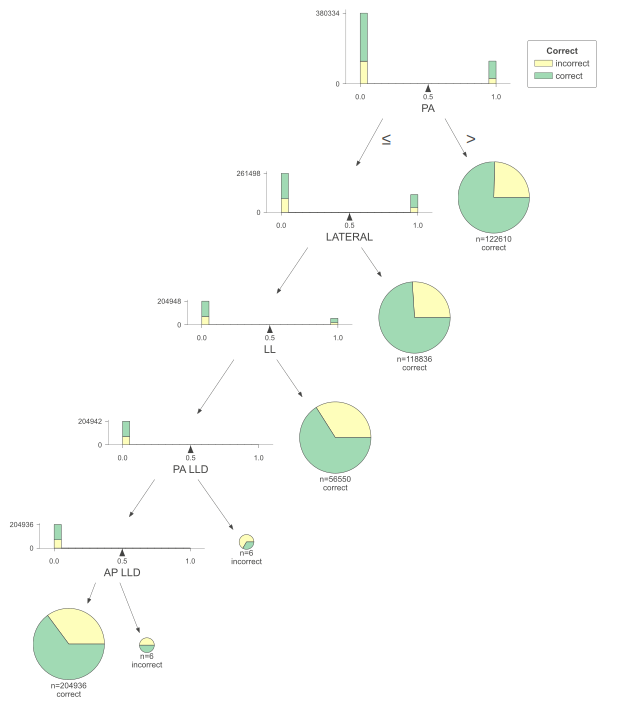

In [14]:
viz_model.view(scale=1.2)

The above plot of a decision tree attempts to explain how the neural network algoritm for Chest X-ray classification performs.

Specifically, it aims to show whether some values of the ViewPosition attribute lead to more errors.

Since ViewPosition is a categorical attribute, reading the visualization is a bit tricky.

Example on how to read a node:

#### Root Node:
- PA (Posteroanterior view): The first split is based on whether the ViewPosition is "PA."
    - If the value is less than or equal to 0.5, it moves left, meaning this is not a "PA" position.
    - If greater than 0.5, it moves right, indicating this is a "PA" position. That's a leaf.
    - The pie chart at this node shows the proportion of correct (green) and incorrect (yellow) predictions in the dataset. There are more correct predictions.


A desirable scenario would be to have pure leaves (only correct or incorrect results). This would indicate that such value of the attribute (e.g. ViewPosition=PA LLD) may be totally easily or difficult for the model.

(83824, 2)
Correct_5
True     0.811832
False    0.188168
Name: proportion, dtype: float64
Accuracy: 0.8119


/opt/anaconda3/envs/neural/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


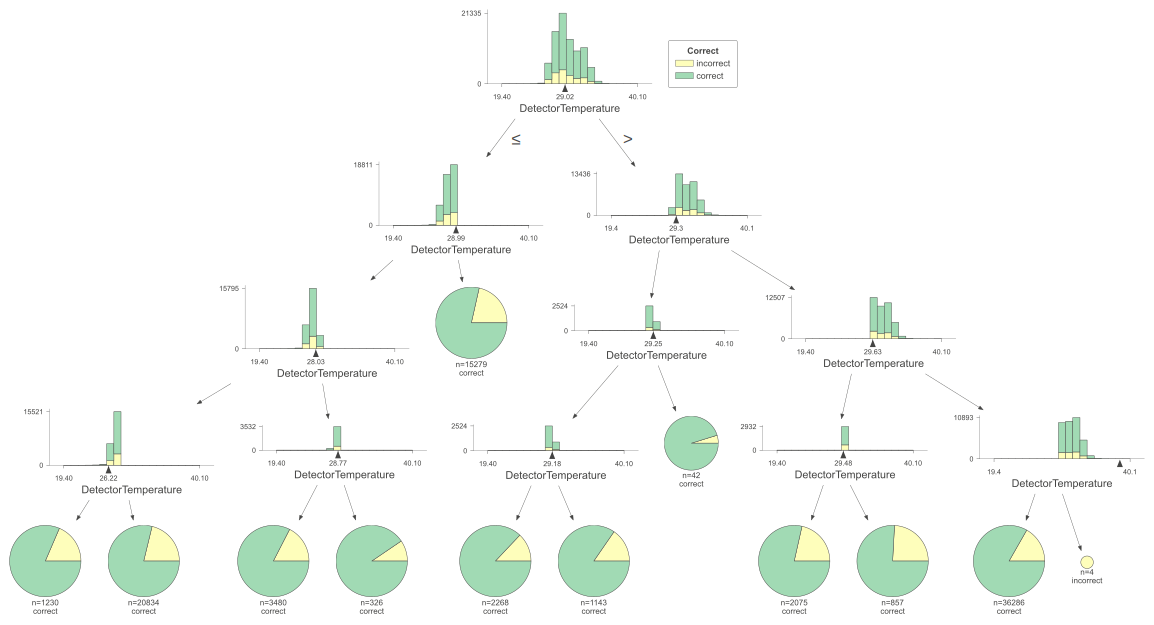

In [41]:
# Select a single attribute for the tree
selected_attribute = "DetectorTemperature"
results_to_explain = "Correct_5"

subset_df = df[
    [
        selected_attribute,
        results_to_explain,
    ]
].dropna()

print(subset_df.shape)

# Create input features
X = subset_df[selected_attribute].to_frame(
    name=selected_attribute
)  # pd.get_dummies(subset_df[selected_attribute], drop_first=True) #
# Use Correct as target
y = subset_df[results_to_explain]
print(y.value_counts(normalize=True))

# Create a decision tree classifier
classifier = DecisionTreeClassifier(random_state=1, max_depth=4)

classifier.fit(X, y)
y_pred = classifier.predict(X)

score = accuracy_score(y, y_pred)
print("Accuracy: {0:0.4f}".format(score))

viz_model = dtreeviz.model(
    classifier,
    X_train=X,
    y_train=y,
    feature_names=X.columns,
    target_name="Correct",
    class_names=["incorrect", "correct"],
)
viz_model.view(scale=1.2)